## Surigae

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from pyproj import CRS, Geod

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# # Statistics
# from sklearn.linear_model import LinearRegression
# from sklearn import linear_model, neighbors
# from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
    'sav_css':        False, # Save cases during fitting
    'sav_inf':        False, # Save cases inferences
}

PTHS = {
    'dat_dir':         '/home/arthur/data/SAR_winddirection/',
    'dsg_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    # 'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    # 'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/winddirection/'
}

In [3]:
dsg  = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 25, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Nb of storms: 161


In [4]:
# dsg.where(dsg.storm_name == 'SURIGAE', drop=True).sortby('time').time
# dsg.where(dsg.storm_name == 'SURIGAE', drop=True).sortby('time').sat_file

In [5]:
# Wind directions
p1   = 'S1B_wind_direction_20210420T094023_20210420T094300.nc'
d1   = xr.open_dataset(PTHS['dat_dir'] + p1)
# Ancillary information
dsg1 = dsg.where(dsg.storm_name == 'SURIGAE', drop=True).sortby('time').isel(time=0)

In [6]:
def rotate(ds, lon_center, lat_center, storm_dir):
    '''Given a (lon, lat) center, (lon, lat) coordinates arrays and a storm_dir,
    first computes the azimuth and radius between the center and and each point of the coordinate arrays,
    then rotates this angle by adding storm_dir and returns the new azimuth (=once rotation is applied).'''
    ds_rot            = ds.copy()
    # If we were given 1D arrays, make a mesh grid
    lons, lats        = np.array(ds['lon']), np.array(ds['lat'])
    
    # Also convert (lon_center, lat_center) to array 
    lons_center       = np.ones_like(lons) * lon_center
    lats_center       = np.ones_like(lats) * lat_center
    
    # Get the direction between target point and center point; 0° is North, 90° is East
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(lons_center, lats_center, lons, lats)
    # Rotate
    forward_az        = forward_az - storm_dir
    ds_rot['wind_dir']= ds_rot['wind_dir'] - storm_dir
    # # Convert to polar  
    # theta             = (90 - forward_az) % 360 # 0° is North, 90° is East
    # # Interpolate on regular (r, th) grid just to check
    return forward_az, dr, ds_rot

In [7]:
lonc        = float(dsg1.lon_center) # °N
latc        = float(dsg1.lat_center) # °E

lons        = np.array(d1.longitude)
lats        = np.array(d1.latitude)

lons_center = np.ones_like(lons) * lonc
lats_center = np.ones_like(lats) * latc

geod_wgs84        = CRS("epsg:4326").get_geod()
forward_az, _, dr = geod_wgs84.inv(lons_center, lats_center, lons, lats)

In [8]:
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

In [9]:
th = get_polar_theta(forward_az) # r is dr

In [10]:
def cart2pol(x, y):
    r  = np.sqrt(x ** 2 + y ** 2)
    th = np.arctan2(y, x)
    return r, th

In [11]:
# _, wdir = cart2pol(d1.normalized_zonal_wind, d1.normalized_meridional_wind)
_, wdir = cart2pol(d1.normalized_meridional_wind, d1.normalized_zonal_wind)
wdir    = np.rad2deg(wdir)

In [12]:
d1['normalized_tangential_wind'] =   1 * np.cos(np.deg2rad((2 * np.pi - wdir) - th))
d1['normalized_radial_wind']     = - 1 * np.sin(np.deg2rad((2 * np.pi - wdir) - th))

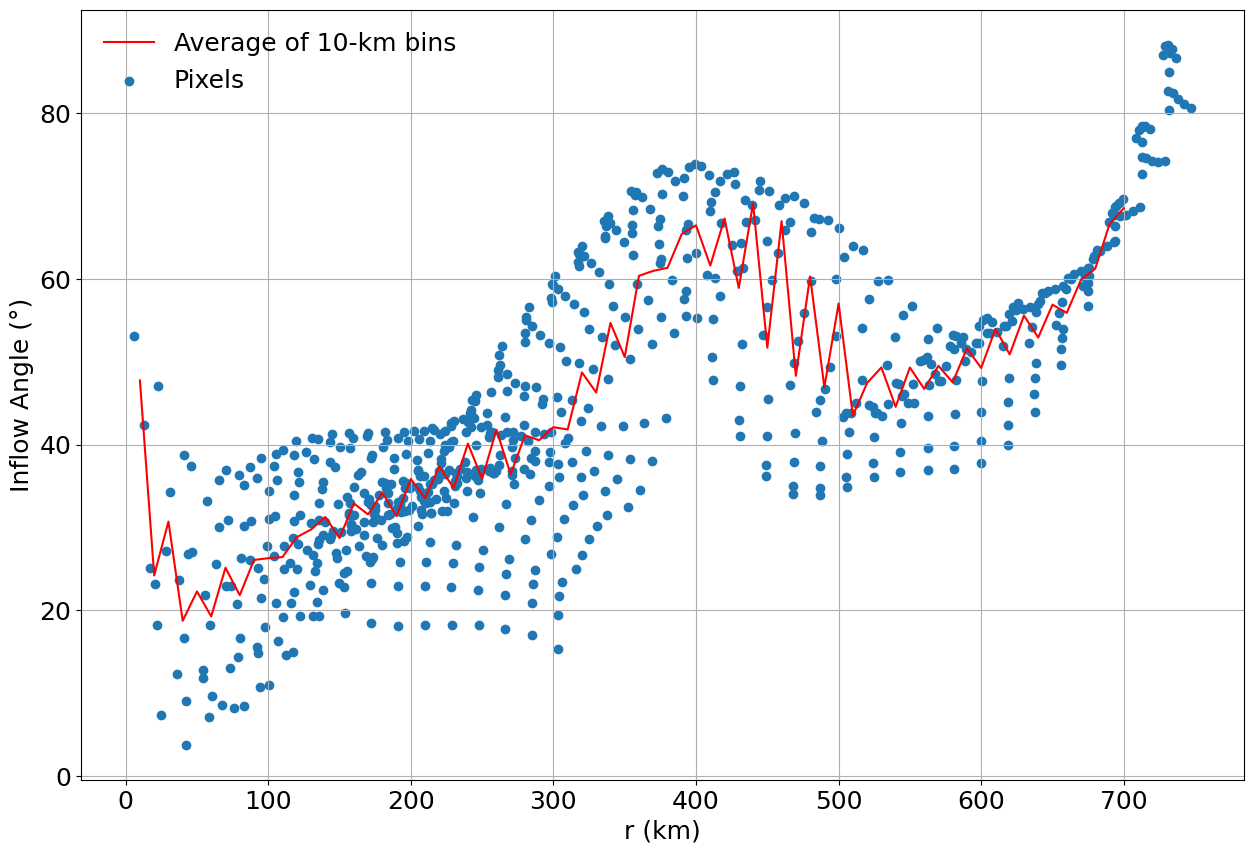

In [13]:
u_v = abs(d1.normalized_radial_wind) / abs(d1.normalized_tangential_wind)

inflow_angle = xr.DataArray(
    data=np.array(np.rad2deg(np.arctan(u_v))),
    coords={'r': np.array(dr) / 1000}
).sortby('r')

inflow_angle.groupby_bins(group=inflow_angle.r, bins=np.linspace(5, 705, 71)).mean().plot(c='r', label='Average of 10-km bins')
plt.scatter(dr / 1000, np.rad2deg(np.arctan(u_v)), label='Pixels')
plt.xlabel('r (km)');plt.ylabel('Inflow Angle (°)')
plt.grid()
plt.legend(frameon=False)

In [14]:
def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

In [56]:
dim_ref      = np.linspace(-500, 500, int((500 // 12.5 * 2) + 1)) * 1000
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)

ds_x, ds_y = pol2cart(dr, np.deg2rad(th))

In [57]:
from scipy.interpolate import griddata

In [58]:
ws = griddata((ds_x.flatten(), ds_y.flatten()), np.array(np.ones_like(lons)).flatten(), (x_ref, y_ref), method='linear')
wd = griddata((ds_x.flatten(), ds_y.flatten()), np.array(wdir).flatten(),               (x_ref, y_ref), method='linear')

In [74]:
def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return( mpl.colors.ListedColormap(colors, name="custom", N=nbCol) )

# Wind speed
palette    = '/home/arthur/scripts/ck22model/PRJCT_RAD_SCAT_CK22_RMW/high_wind_speed.pal'
cwnd       = getColorMap(rgbFile=palette)
normalizer = Normalize(0, 80)

/tmp/ipykernel_14311/2463759044.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im           = ax.pcolormesh(x / 1000, y / 1000, dsg1.wind_speed, cmap=cwnd, norm=normalizer)


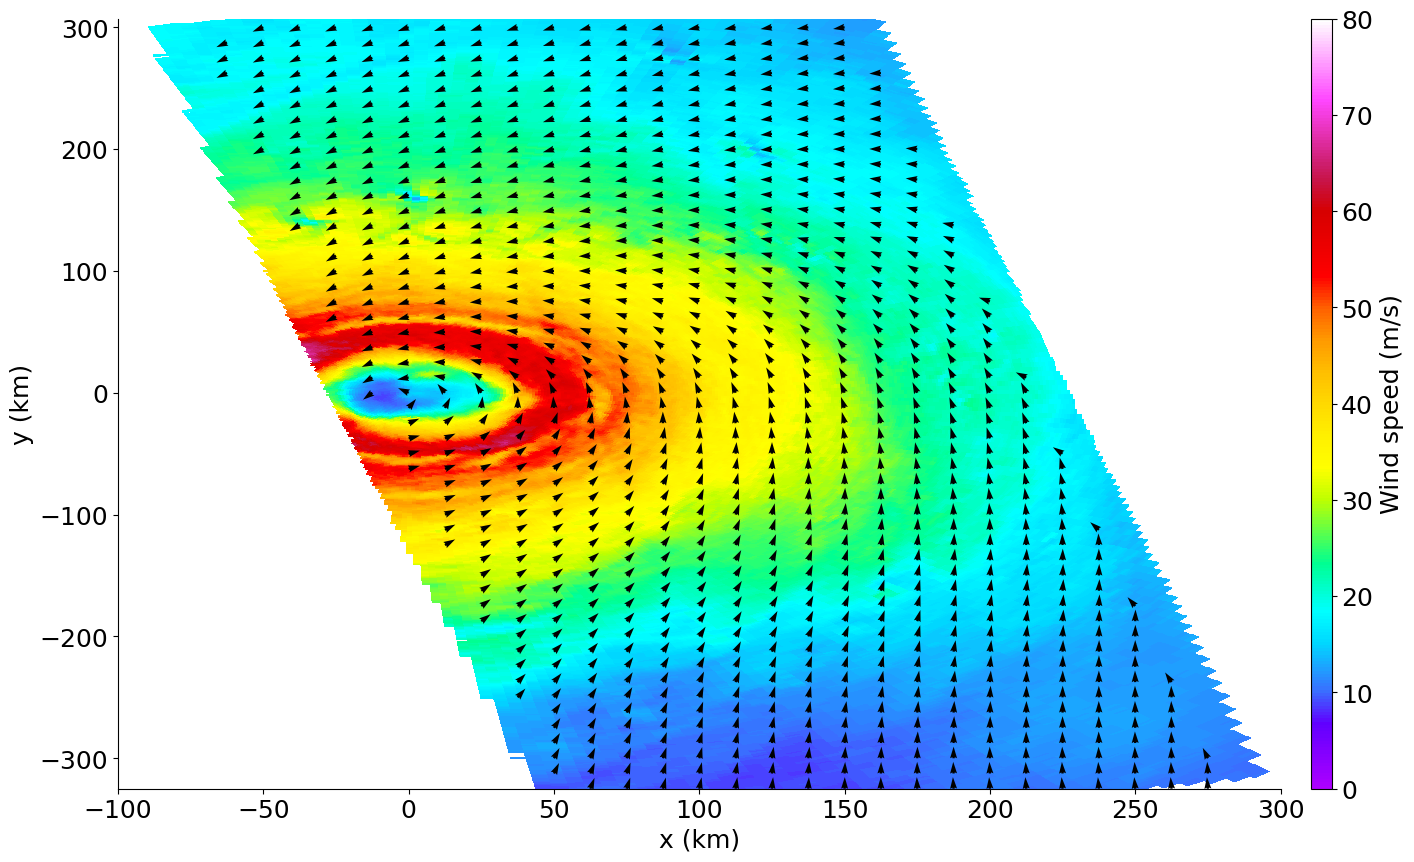

In [137]:
U, V    = pol2cart(ws * 50, np.pi / 2 - np.deg2rad(wd))
    
# Plot
fig, ax = plt.subplots()

# Wind speed
x_sar, y_sar = pol2cart(dsg1.rad, np.pi/2 - np.deg2rad(dsg1.theta - float(dsg1.rotation_angle)))
im           = ax.pcolormesh(x / 1000, y / 1000, dsg1.wind_speed, cmap=cwnd, norm=normalizer)

# Wind directions
# img     = ax.barbs(x_ref / 1000, y_ref / 1000, U, V, color='k')
img     = ax.quiver(x_ref / 1000, y_ref / 1000, U, V, color='k', scale=5e3)

# Colorbar
cb_ax = fig.add_axes([0.92, 0.11, 0.014, 0.77])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
ax.set_xlim(-100, 300);ax.set_ylim(-325, 307)
ax.spines[['right', 'top']].set_visible(False)